#Databse clone and red_mask applying.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, UpSampling2D
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import activations
from tensorflow.keras import layers
import numpy as np

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

In [ ]:
img = cv2.imread('SO2_Indian_Cloud_data/SO2/2020-05-23_SO2.png')
print(img.shape)
small = cv2.resize(img, (128,128))

(880, 1000, 3)


In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
def red_mask(img):
  #hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) 
  hsv = cv2.cvtColor(small, cv2.COLOR_BGR2HSV)
  lower_red = np.array([0,50,50])
  upper_red = np.array([10,255,255])

  lower_blue = np.array([35, 140, 60]) 
  upper_blue = np.array([255, 255, 180]) 

  # preparing the mask to overlay 
  mask = cv2.inRange(hsv, lower_red, upper_red) 
      
  # The black region in the mask has the value of 0, 
  # so when multiplied with original image removes all non-blue regions 
  #result = cv2.bitwise_and(img, img, mask = mask) 
  result = cv2.bitwise_and(small, small, mask = mask) 

  #cv2_imshow(cv2.resize(result, (128,128)))
  #cv2_imshow(small)
  #cv2_imshow(result)
  return result

In [ ]:
img1 = red_mask(small)

(128, 128, 3)


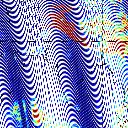

In [ ]:
print(small.shape)
cv2_imshow(small)

#Preparing output data as red mask of input data

In [ ]:
import pandas as pd
df = pd.read_csv('SO2_Indian_Cloud_data/SO2_img_data.csv')

In [ ]:
df.head()

,Date,file_name
0,12/24/2019,2019-12-24_SO2.png
1,12/25/2019,2019-12-25_SO2.png
2,12/26/2019,2019-12-26_SO2.png
3,12/27/2019,2019-12-27_SO2.png
4,12/28/2019,2019-12-28_SO2.png


In [ ]:
sample_ip = []
c = 0
for i in df['file_name'][0:121]:
  sample_ip.append(cv2.resize(cv2.imread('SO2_Indian_Cloud_data/SO2/' + str(i)), (128,128)))

In [ ]:
import numpy as np
input_data = np.array(sample_ip)
input_data.shape

(121, 128, 128, 3)

In [ ]:
sample_op = []
c = 0
for i in df['file_name'][0:121]:
  img = cv2.imread('SO2_Indian_Cloud_data/SO2/' + str(i))
  small = cv2.resize(img, (128,128))
  sample_op.append(red_mask(small))
output_data = np.array(sample_op)
output_data.shape

(121, 128, 128, 3)

In [ ]:
val_ip = []
for i in df['file_name'][121:]:
  val_ip.append(cv2.resize(cv2.imread('SO2_Indian_Cloud_data/SO2/' + str(i)), (128,128)))
val_ip = np.array(val_ip)
val_op = []
for i in df['file_name'][121:]:
  img = cv2.imread('SO2_Indian_Cloud_data/SO2/' + str(i))
  small = cv2.resize(img, (128,128))
  val_op.append(red_mask(small))
val_op = np.array(val_op)

In [ ]:
df['file_name'][0:121]

0      2019-12-24_SO2.png
1      2019-12-25_SO2.png
2      2019-12-26_SO2.png
3      2019-12-27_SO2.png
4      2019-12-28_SO2.png
              ...        
116    2020-04-18_SO2.png
117    2020-04-19_SO2.png
118    2020-04-20_SO2.png
119    2020-04-21_SO2.png
120    2020-04-22_SO2.png
Name: file_name, Length: 121, dtype: object

#Autoencoder code

In [ ]:
segment = Sequential()
#Encoder arch.
segment.add(Conv2D(32, (3,3), input_shape = (128,128,3), activation = 'relu', padding = 'same'))
segment.add(MaxPooling2D(pool_size = (2,2)))
segment.add(Conv2D(64, (3,3), activation='relu', padding = 'same'))
segment.add(MaxPooling2D(pool_size = (2,2)))
segment.add(Conv2D(3, (3,3), activation = 'relu', padding = 'same'))

#Decoder arch.
segment.add(UpSampling2D(size = (2,2)))
segment.add(Conv2D(32, (3,3), activation = 'relu', padding = 'same'))
segment.add(UpSampling2D(size = (2,2)))
segment.add(Conv2D(3, (3,3), activation = 'relu', padding = 'same'))
segment.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 3)         1731      
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 64, 64, 32)       

In [ ]:
segment.compile(optimizer='adam', loss='mse', metrics = ['accuracy'])

In [ ]:
a_e = segment.fit(input_data, output_data,
            epochs=50,
            batch_size=32,
            shuffle=True,
            validation_data=(val_ip, val_op))
            #callbacks=[TensorBoard(log_dir='/tmp/autoencoder'), early_stopper]

Epoch 1/50
4/4 [==============================] - 6s 1s/step - loss: 1053.4126 - accuracy: 0.2887 - val_loss: 694.4429 - val_accuracy: 0.4558
Epoch 2/50
4/4 [==============================] - 6s 1s/step - loss: 869.1921 - accuracy: 0.5560 - val_loss: 694.2845 - val_accuracy: 0.5688
Epoch 3/50
4/4 [==============================] - 6s 1s/step - loss: 868.2629 - accuracy: 0.4159 - val_loss: 692.6717 - val_accuracy: 0.3611
Epoch 4/50
4/4 [==============================] - 6s 1s/step - loss: 865.1765 - accuracy: 0.3704 - val_loss: 689.6027 - val_accuracy: 0.2716
Epoch 5/50
4/4 [==============================] - 6s 1s/step - loss: 855.6310 - accuracy: 0.2592 - val_loss: 674.8951 - val_accuracy: 0.2328
Epoch 6/50
4/4 [==============================] - 6s 1s/step - loss: 812.7205 - accuracy: 0.1705 - val_loss: 638.4247 - val_accuracy: 0.0935
Epoch 7/50
4/4 [==============================] - 6s 1s/step - loss: 742.2876 - accuracy: 0.1066 - val_loss: 609.9458 - val_accuracy: 0.0712
Epoch 8/50
4

'\njson_file = segment.to_json()\nwith open(\'model_SO2.json\', "w") as file:\n   file.write(json_file)\n'

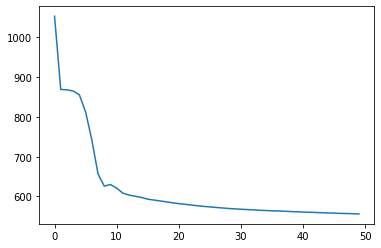

In [ ]:
import matplotlib.pyplot as plt
plt.plot(a_e.history['loss'])
"""
json_file = segment.to_json()
with open('model_SO2.json', "w") as file:
   file.write(json_file)
"""

#Plotting and Drawing inference from the image

In [ ]:
import cv2
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
def grad_img(img):
  pixels = np.float32(img.reshape(-1, 3))

  n_colors = 7
  criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, .1)
  flags = cv2.KMEANS_RANDOM_CENTERS

  _, labels, palette = cv2.kmeans(pixels, n_colors, None, criteria, 10, flags)
  _, counts = np.unique(labels, return_counts=True)
  dominant = palette[np.argmax(counts)]
  average = img.mean(axis=0).mean(axis=0)
  avg_patch = np.ones(shape = img.shape, dtype=np.uint8)*np.uint8(average)

  indices = np.argsort(counts)[::-1]   
  freqs = np.cumsum(np.hstack([[0], counts[indices]/counts.sum()]))
  rows = np.int_(img.shape[0]*freqs)

  dom_patch = np.zeros(shape = img.shape, dtype=np.uint8)
  for i in range(len(rows) - 1):
    dom_patch[rows[i]:rows[i + 1], :, :] += np.uint8(palette[indices[i]])
  return(dom_patch)
  #fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12,6))
  #ax0.imshow(avg_patch)
  #ax0.set_title('Average color')
  #ax0.axis('off')
  #ax1.imshow(dom_patch)
  #ax1.set_title('Dominant colors')
  #ax1.axis('scaled')
  #plt.show(fig)
  #cv2_imshow(dom_patch)
  

In [ ]:
final = []
dom_matrix = []
for i in df['file_name']:
  img = cv2.imread('SO2_Indian_Cloud_data/SO2/' + str(i))
  #print(img.shape)
  small = cv2.resize(img, (128,128))
  X = small.reshape([1] + list(small.shape)) 
  predicted = segment.predict(X)
  final_img = predicted.reshape((128, 128, 3))
#cv2_imshow(final_img)
#cv2_imshow(small)

  dom_patch = grad_img(final_img)
  dom_matrix.append(dom_patch[:, :, 1])
#cv2_imshow(dom_patch[:, :, 2])
  l = list(set(dom_patch[:, :, 1].flatten()))
  final.append(sorted(l))
  #set(dom_patch[:, :, 0].flatten())

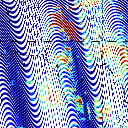

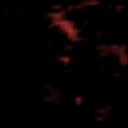

In [ ]:
#print(final[0][0])
#set(dom_matrix[0].flatten())
img = cv2.imread('SO2_Indian_Cloud_data/SO2/2020-06-24_SO2.png')
  #print(img.shape)
small = cv2.resize(img, (128,128))
X = small.reshape([1] + list(small.shape)) 
predicted = segment.predict(X)
final_img = predicted.reshape((128, 128, 3))
#cv2_imshow(img)
cv2_imshow(small)
cv2_imshow(final_img)

In [ ]:
val = []
for i in dom_matrix:
  s = 0
  index = 0
  arr = np.array(i).astype(int)
  col = arr[:, 0]
  for j in range(len(col[1:])):
    if int(col[j]) != int(col[j - 1]):
      #print(col[j])  
      index += 1
    else:
      s += int(col[j]) * index
  #print(col[1:])
  val.append(s)
#print(s)
#print(index)
print(val)

[1037, 1025, 1084, 1640, 1212, 1415, 1146, 1056, 1113, 1068, 1458, 1036, 1905, 874, 1396, 984, 1244, 1152, 1345, 1881, 1136, 1323, 1054, 1205, 937, 1204, 1788, 1107, 1630, 1038, 1475, 1337, 1416, 1317, 1346, 1524, 933, 1476, 956, 1244, 1242, 1192, 1513, 1048, 1559, 1261, 1473, 1374, 1323, 1744, 1208, 1522, 1095, 1578, 830, 1102, 1277, 1184, 1201, 1012, 1622, 889, 1317, 1161, 1254, 857, 679, 972, 866, 1234, 879, 1114, 889, 1104, 1248, 755, 975, 860, 1393, 754, 900, 1083, 782, 1015, 998, 1125, 1182, 1201, 1101, 1140, 1645, 1066, 1403, 995, 1280, 763, 859, 1291, 759, 912, 923, 854, 698, 854, 876, 1088, 1258, 860, 1114, 915, 1413, 1107, 1079, 1016, 810, 835, 712, 852, 927, 1034, 1194, 948, 1422, 981, 1140, 940, 1328, 946, 873, 1014, 714, 1013, 651, 1007, 810, 765, 561, 501, 900, 722, 876, 810, 966, 1027, 820, 896, 688, 877, 729, 1227, 525, 544, 474, 985, 572, 567, 831, 826, 646, 660, 690, 684, 600, 716, 709, 906, 711, 471, 396, 607, 767, 640, 594, 499, 679, 802, 639, 744, 540, 401, 404, 58

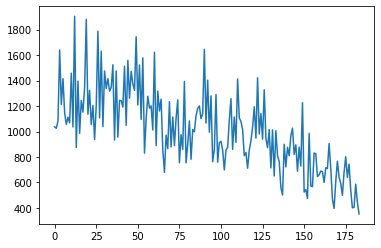

In [ ]:
from matplotlib import pyplot as plt
plt.plot(val)

In [ ]:
df_val = pd.Series(val)
df_val.head()

0    796
1    710
2    784
3    757
4    846
dtype: int64

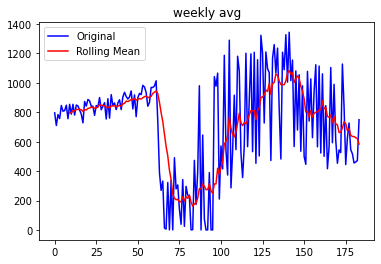

In [ ]:
weekly_avg = df_val.rolling(window=10).mean()
plt.plot(df_val, color='blue', label='Original')
plt.plot(weekly_avg, color='red', label='Rolling Mean')
plt.legend(loc='best')
plt.title('weekly avg')
plt.savefig('final_graph.png')

#Extra code

In [ ]:
test = final_img.T[20:23, :, :].T
cv2_imshow(cv2.resize(test, (128, 128)))


In [ ]:
predicted.shape

(1, 30, 30, 64)

In [ ]:
new_img = segment.predict(X)

In [ ]:
new_img.shape

(1, 30, 30, 3)

In [ ]:
type(new_img)

numpy.ndarray

In [ ]:
final_img = new_img.reshape((30, 30, 3))

In [ ]:
cv2_imshow(new_img[0])

In [ ]:
new_data = val_so2

In [ ]:
old_data = val

In [ ]:
new_data

In [ ]:
old_data

In [ ]:
final_data = []
for i in range(184):
  final_data.append((new_data[i] + old_data[i]) // 2)

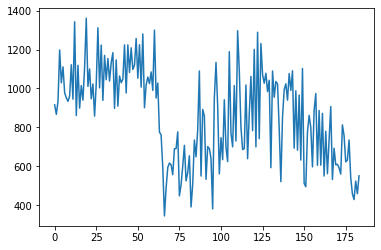

In [ ]:
plt.plot(final_data)

In [ ]:
df_val = pd.Series(test)
df_val.head()

0     916
1     867
2     934
3    1198
4    1029
dtype: int64

Text(0.5, 1.0, 'weekly avg')

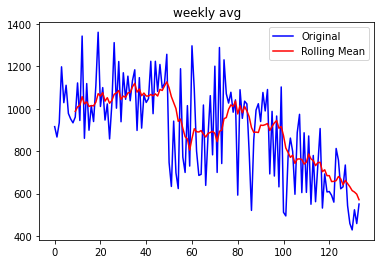

In [ ]:
weekly_avg = df_val.rolling(window=10).mean()
plt.plot(df_val, color='blue', label='Original')
plt.plot(weekly_avg, color='red', label='Rolling Mean')
plt.legend(loc='best')
plt.title('weekly avg')

In [ ]:
test = final_data[0:50] + final_data[100:184]
plt.plot(test)